In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from py_pcha import PCHA
from scipy.signal import resample, savgol_filter, medfilt
from scipy import stats
from sklearn.linear_model import LinearRegression
from minisom import MiniSom
from scipy.signal import find_peaks, cheby2, filtfilt, iirfilter, gaussian, convolve, welch
from scipy.optimize import curve_fit
from scipy.signal import periodogram
from scipy.integrate import trapz
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

def setup_mpl():
    mpl.rcParams['font.family'] = 'Times New Roman'
    mpl.rcParams['lines.linewidth'] = 2
    return None
setup_mpl()

In [2]:
np.random.seed(42)
N = 100

In [3]:
data_dict = {}

for d in Path('../data/raw/dataset_extended').glob('D1_*'):
    d_name = d.name
    data_dict[d_name] = {}
    team_inf = pd.read_csv(list(d.glob('team_info.csv'))[0])
    for id_ in d.glob('ID_*'):
        id_name = id_.name
        data_dict[d_name][id_name] = {}
        
        for round_ in id_.glob('round_*'):
            round_name = round_.name
            data_dict[d_name][id_name][round_name] = {}
            
            for phase in round_.glob('phase*'):
                phase_name = phase.name
                data_dict[d_name][id_name][round_name][phase_name] = {} 
                
                response_df = pd.read_csv(list(phase.glob('response.csv'))[0], index_col=None)
                key = "participant_ID" if "participant_ID" in response_df.columns.tolist() else "particpant_ID"

                for file in phase.glob('*.csv'):
                    if file.name not in ('response.csv',):
                        temp_df = pd.read_csv(file, index_col=None)
                        temp_df['time'] = pd.to_datetime(temp_df['time'], format='%Y-%m-%d %H:%M:%S.%f')
                        temp_df['time_passed'] = (temp_df['time'] - temp_df['time'].iloc[0]).apply(lambda x: x.total_seconds())

                        if team_inf[team_inf.ID == id_name]['Puzzler'].tolist()[0] == 0:
                            temp_df['role'] = 'Puzzler'
                        else:
                            temp_df['role'] = 'Instructor'
                        temp_df['team'] = team_inf[team_inf.ID == id_name]['Team'].tolist()[0]

                        temp_df['p_ID'] = response_df[key].tolist()[0]

                        # Save dataframe in nested dictionary
                        data_dict[d_name][id_name][round_name][phase_name][file.stem] = temp_df
                    else:
                        temp_df = pd.read_csv(file, index_col=None)
                        data_dict[d_name][id_name][round_name][phase_name][file.stem] = temp_df

In [4]:
# define the function for first-order regression
def first_order_func(x, a, b):
    return a * x + b

# define the function for second-order regression
def second_order_func(x, a, b, c):
    return a * x**2 + b * x + c

def third_order_func(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

In [80]:
X_eda = []
X_bvp = []
X_temp = []
X_hr = []

X = []
roles = []
phases = []
participant_ID = []


for cohort in data_dict.keys():
    for id in data_dict[cohort].keys():
        for phase in ['phase1', 'phase2', 'phase3']:
            eda_ts_concat = []
            hr_ts_concat = []
            bvp_ts_concat = []
            temp_ts_concat = []
            q_attentive = []
            q_upset = []
            q_hostile = []
            q_alert = []
            q_ashamed = []
            q_inspired = []
            q_nervous = []
            q_determined = []
            q_afraid = []
            q_active = []
            q_frustrated = []
            for round_ in data_dict[cohort][id].keys():
                
                eda_ts = data_dict[cohort][id][round_][phase]['EDA'].EDA.values
                hr_ts = data_dict[cohort][id][round_][phase]['HR'].HR.values
                bvp_ts = data_dict[cohort][id][round_][phase]['BVP'].BVP.values
                temp_ts = data_dict[cohort][id][round_][phase]['TEMP'].TEMP.values
                q_attentive_temp = data_dict[cohort][id][round_][phase]['response'].attentive.values
                q_upset_temp = data_dict[cohort][id][round_][phase]['response'].upset.values
                q_hostile_temp = data_dict[cohort][id][round_][phase]['response'].hostile.values
                q_alert_temp = data_dict[cohort][id][round_][phase]['response'].alert.values
                q_ashamed_temp = data_dict[cohort][id][round_][phase]['response'].ashamed.values
                q_inspired_temp = data_dict[cohort][id][round_][phase]['response'].inspired.values
                q_nervous_temp = data_dict[cohort][id][round_][phase]['response'].nervous.values
                q_determined_temp = data_dict[cohort][id][round_][phase]['response'].determined.values
                q_afraid_temp = data_dict[cohort][id][round_][phase]['response'].afraid.values
                q_active_temp = data_dict[cohort][id][round_][phase]['response'].active.values
                q_frustrated_temp = data_dict[cohort][id][round_][phase]['response'].frustrated.values

                # Conduct upsampling from 1hz and 4hz to 64hz
                eda_ts = resample(eda_ts, 19200) #Assumes periodic
                hr_ts = resample(hr_ts, 19200)
                temp_ts = resample(temp_ts, 19200)
                bvp_ts = resample(bvp_ts, 19200)
                
                eda_ts_concat.append(eda_ts)
                hr_ts_concat.append(hr_ts)
                bvp_ts_concat.append(bvp_ts)
                temp_ts_concat.append(temp_ts)

                q_attentive.append(q_attentive_temp[0] if len(q_attentive_temp) != 0 else np.nan)
                q_upset.append(q_upset_temp[0] if len(q_upset_temp) != 0 else np.nan)
                q_hostile.append(q_hostile_temp[0] if len(q_hostile_temp) != 0 else np.nan)
                q_alert.append(q_alert_temp[0] if len(q_alert_temp) != 0 else np.nan)
                q_ashamed.append(q_ashamed_temp[0] if len(q_ashamed_temp) != 0 else np.nan)
                q_inspired.append(q_inspired_temp[0] if len(q_inspired_temp) != 0 else np.nan)
                q_nervous.append(q_nervous_temp[0] if len(q_nervous_temp) != 0 else np.nan)
                q_determined.append(q_determined_temp[0] if len(q_determined_temp) != 0 else np.nan)
                q_afraid.append(q_afraid_temp[0] if len(q_afraid_temp) != 0 else np.nan)
                q_active.append(q_active_temp[0] if len(q_active_temp) != 0 else np.nan)
                q_frustrated.append(q_frustrated_temp[0] if len(q_frustrated_temp) != 0 else np.nan)

                role = data_dict[cohort][id][round_][phase]['EDA'].role.tolist()[0]
                p_id =  data_dict[cohort][id][round_][phase]['EDA'].p_ID.tolist()[0]

            roles.append(role)
            phases.append(phase)
            participant_ID.append(p_id)

            # Average over rounds
            eda_ts_concat = np.vstack(eda_ts_concat).mean(axis=0)[64*5 : 19200  - 64*5]
            hr_ts_concat = np.vstack(hr_ts_concat).mean(axis=0)[64*5 : 19200  - 64*5]
            bvp_ts_concat = np.vstack(bvp_ts_concat).mean(axis=0)[64*5 : 19200  - 64*5]
            temp_ts_concat = np.vstack(temp_ts_concat).mean(axis=0)[64*5 : 19200  - 64*5]

            q_attentive = np.nanmedian(q_attentive)
            q_upset = np.nanmedian(q_upset)
            q_hostile = np.nanmedian(q_hostile)
            q_alert = np.nanmedian(q_alert)
            q_ashamed = np.nanmedian(q_ashamed)
            q_inspired = np.nanmedian(q_inspired)
            q_nervous = np.nanmedian(q_nervous)
            q_determined = np.nanmedian(q_determined)
            q_afraid = np.nanmedian(q_afraid)
            q_active = np.nanmedian(q_active)

            # Normalizing
            eda_ts_concat = (eda_ts_concat - eda_ts_concat.min())/(eda_ts_concat.max()-eda_ts_concat.min())#eda_ts_concat / np.linalg.norm(eda_ts_concat)
            hr_ts_concat = (hr_ts_concat - hr_ts_concat.min())/(hr_ts_concat.max()-hr_ts_concat.min())#hr_ts_concat / np.linalg.norm(hr_ts_concat)
            bvp_ts_concat = (bvp_ts_concat - bvp_ts_concat.min())/(bvp_ts_concat.max()-bvp_ts_concat.min())#bvp_ts_concat / np.linalg.norm(bvp_ts_concat)
            temp_ts_concat = (temp_ts_concat - temp_ts_concat.min())/(temp_ts_concat.max()-temp_ts_concat.min())#temp_ts_concat / np.linalg.norm(temp_ts_concat)

            
            # Median filter
            #hr_ts_concat = medfilt(hr_ts_concat, 64*5 + 1)
            #temp_ts_concat = savgol_filter(temp_ts_concat, 64*4, 2)
            
            
            # Source for pre-processing steps: https://www.mdpi.com/1424-8220/23/7/3565
            # BVP
            fs = 64  # Sampling frequency (Hz)
            f_stop = 5  # Stopband frequency (Hz)
            f_pass = 0.5  # Passband frequency (Hz)
            stop_db = 20  # Stopband attenuation (dB)
            nyquist_rate = fs/2  # Nyquist rate (Hz)
            wp = f_pass/nyquist_rate  # Passband frequency (normalized)
            ws = f_stop/nyquist_rate  # Stopband frequency (normalized)
            b, a = iirfilter(N=4, Wn=[wp, ws], rs=stop_db, btype='bandpass', analog=False, ftype='cheby2', output='ba')
            bvp_filtered = filtfilt(b, a, bvp_ts_concat)
            bvp_peaks, _ = find_peaks(bvp_filtered, distance=64*0.4, height=0)
            peak_to_peak_intervals = np.diff(bvp_peaks)
            valid_intervals = peak_to_peak_intervals[(peak_to_peak_intervals >=  64*0.5) & (peak_to_peak_intervals <= 64*1.2)]

            # EDA
            # Gaussian low pass filter (40-point window, sigma 400 ms)
            window_length = 40
            sigma = 64*0.4
            #std = sigma / (window_length - 1) * (2 * np.sqrt(2 * np.log(2)))
            window = gaussian(window_length, sigma)
            window /= np.sum(window)
            eda_filtered = convolve(eda_ts_concat, window, mode='same')

            # Storing series for plotting
            X_eda.append(eda_filtered)
            X_hr.append(hr_ts_concat)
            X_bvp.append(bvp_filtered)
            X_temp.append(temp_ts_concat)


            # Stats
            hr_mean = hr_ts_concat.mean()
            hr_std = hr_ts_concat.std()

            eda_mean = eda_filtered.mean()
            eda_std = eda_filtered.std()

            temp_mean = temp_ts_concat.mean()
            temp_std = temp_ts_concat.std()


            # Regression coefficients
            # HR
            hr_1_coeffs, _ = curve_fit(first_order_func, np.arange(len(hr_ts_concat)), hr_ts_concat)
            hr_2_coeffs, _= curve_fit(second_order_func, np.arange(len(hr_ts_concat)), hr_ts_concat)
            hr_3_coeffs, _ = curve_fit(third_order_func, np.arange(len(hr_ts_concat)), hr_ts_concat)
            # Disregarding intercept
            hr_1_coeffs = hr_1_coeffs[:-1]
            hr_2_coeffs = hr_2_coeffs[:-1]
            hr_3_coeffs = hr_3_coeffs[:-1]

            # EDA
            eda_1_coeffs, _ = curve_fit(first_order_func, np.arange(len(eda_filtered)), eda_filtered)
            eda_2_coeffs, _ = curve_fit(second_order_func, np.arange(len(eda_filtered)), eda_filtered)
            eda_3_coeffs, _ = curve_fit(third_order_func, np.arange(len(eda_filtered)), eda_filtered)
            # Disregarding intercept
            eda_1_coeffs = eda_1_coeffs[:-1]
            eda_2_coeffs = eda_2_coeffs[:-1]
            eda_3_coeffs = eda_3_coeffs[:-1]

            # TEMP
            temp_1_coeffs, _ = curve_fit(first_order_func, np.arange(len(temp_ts_concat)), temp_ts_concat)
            temp_2_coeffs, _ = curve_fit(second_order_func, np.arange(len(temp_ts_concat)), temp_ts_concat)
            temp_3_coeffs, _ = curve_fit(third_order_func, np.arange(len(temp_ts_concat)), temp_ts_concat)
            # Disregarding intercept
            temp_1_coeffs = temp_1_coeffs[:-1]
            temp_2_coeffs = temp_2_coeffs[:-1]
            temp_3_coeffs = temp_3_coeffs[:-1]
            
            # BVP
            dx = 1 # unit spacing
            dydx = np.gradient(bvp_filtered, dx)  
            dy2dx2 = np.gradient(dydx, dx)

            bvp_first_dev_mean = dydx.mean()
            bvp_second_dev_mean = dy2dx2.mean()
            bvp_first_dev_std = dydx.std()
            bvp_second_dev_std = dy2dx2.std()

            # gradients
            eda_dydx = np.diff(eda_filtered)
            eda_dy2dx2 = np.diff(eda_dydx)
            eda_dydx_mean = eda_dydx.mean()
            eda_dy2dx2_mean = eda_dy2dx2.mean()            
            eda_dydx_std = eda_dydx.std()
            eda_dy2dx2_std = eda_dy2dx2.std()

            hr_dydx = np.diff(hr_ts_concat)
            hr_dy2dx2 = np.diff(hr_dydx)
            hr_dydx_mean = hr_dydx.mean()
            hr_dy2dx2_mean = hr_dy2dx2.mean()            
            hr_dydx_std = hr_dydx.std()
            hr_dy2dx2_std = hr_dy2dx2.std()

            temp_dydx = np.diff(temp_ts_concat)
            temp_dy2dx2 = np.diff(temp_dydx)
            temp_dydx_mean = temp_dydx.mean()
            temp_dy2dx2_mean = temp_dy2dx2.mean()            
            temp_dydx_std = temp_dydx.std()
            temp_dy2dx2_std = temp_dy2dx2.std()


            # Frequency
            ppi_mean = valid_intervals.mean()
            ppi_std = valid_intervals.std()
            n_peaks = len(bvp_peaks)
 

            # statistics
            bvp_std = bvp_filtered.std()
            bvp_median = np.median(bvp_filtered)


            X.append([
                q_attentive,
                q_upset,
                q_hostile,
                q_alert,
                q_ashamed, 
                q_inspired,
                q_nervous, 
                q_determined, 
                q_afraid,
                q_active,

                hr_mean,
                hr_std,
                eda_mean,
                eda_std,
                temp_mean,
                temp_std,
                hr_ts_concat.max(),
                hr_ts_concat.min(),
                eda_filtered.max(),
                eda_filtered.min(),
                temp_ts_concat.max(),
                temp_ts_concat.min(),

                *hr_1_coeffs,
                *hr_2_coeffs,
                *hr_3_coeffs,
                *eda_1_coeffs,
                *eda_2_coeffs,
                *eda_3_coeffs,
                eda_dydx_mean,
                eda_dy2dx2_mean,
                eda_dydx_std,
                eda_dy2dx2_std,
                *temp_1_coeffs,
                *temp_2_coeffs,
                *temp_3_coeffs,
                ppi_mean,
                ppi_std,
                n_peaks,
                
                bvp_std,
                bvp_median,
                bvp_first_dev_mean,
                bvp_second_dev_mean,
                bvp_first_dev_std,
                bvp_second_dev_std,

                hr_dydx_mean,
                hr_dy2dx2_mean,            
                hr_dydx_std,
                hr_dy2dx2_std,

                temp_dydx_mean,
                temp_dy2dx2_mean,            
                temp_dydx_std,
                temp_dy2dx2_std,


                ])

phases = np.array(phases)
roles = np.array(roles)
X = np.vstack(X)
X_eda = np.vstack(X_eda)
X_temp = np.vstack(X_temp)
X_bvp = np.vstack(X_bvp)
X_hr = np.vstack(X_hr)

In [81]:
X = (X - X.min(0)) / (X.ptp(0) + 1e-6)

In [82]:
from py_pcha import PCHA
X = X.copy()
# Notice that for this implementation we transform the data matrix X
XC, S, C, SSE, varexl = PCHA(X.T, noc=3)
S = np.array(S)

[[12.70973615  5.777408    5.84741118]
 [ 5.777408   11.71709353  7.42106579]
 [ 5.84741118  7.42106579 15.48140039]]
269.66552116158675


In [83]:
phase1_idx = np.where(phases=='phase1')[0]
phase2_idx = np.where(phases=='phase2')[0]
phase3_idx = np.where(phases=='phase3')[0]

puzzler_idx = np.where(roles=='Puzzler')[0]
instructor_idx = np.where(roles=='Instructor')[0]

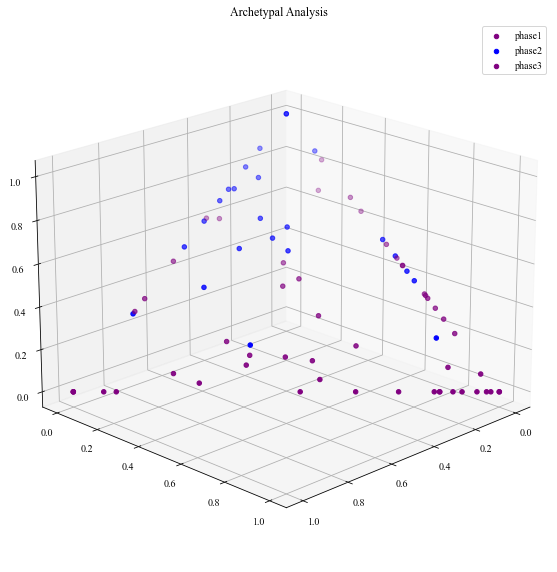

In [84]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(S[0,phase1_idx], S[1,phase1_idx], S[2, phase1_idx], c='purple', marker='o', label='phase1')
ax.scatter(S[0,phase2_idx], S[1,phase2_idx], S[2, phase2_idx], c='blue', marker='o', label='phase2')
ax.scatter(S[0,phase3_idx], S[1,phase3_idx], S[2, phase3_idx], c='purple', marker='o', label='phase3')
ax.legend()
ax.set_title('Archetypal Analysis')
ax.view_init(elev=20, azim=45)
plt.show()

In [85]:
from py_pcha import PCHA
ARI = []
NMI = []
for i in range(N):
    try:
        # Notice that for this implementation we transform the data matrix X
        XC, S, C, SSE, varexl = PCHA(X.copy().T, noc=3, verbose=False)
        S = np.array(S)
        ARI.append(adjusted_rand_score(phases, S.argmax(axis=0)))
        NMI.append(normalized_mutual_info_score(phases, S.argmax(axis=0)))
    except:
        continue

[[13.40977944  6.23311627  6.43403925]
 [ 6.23311627 12.63377957  6.40969787]
 [ 6.43403925  6.40969787 13.8027342 ]]
267.54575092997595
[[12.86785251  6.90499444  6.45607479]
 [ 6.90499444 16.33915583  6.07927429]
 [ 6.45607479  6.07927429  9.91230463]]
267.7604091950009
[[13.97340982  6.84720031  7.06829774]
 [ 6.84720031 11.34826309  5.8046992 ]
 [ 7.06829774  5.8046992  13.23793259]]
264.71564956750274
[[13.55622024  7.14869231  7.02722419]
 [ 7.14869231 11.93993156  5.69957697]
 [ 7.02722419  5.69957697 12.75286126]]
264.28127599275433
[[12.21359573  5.4918581   6.36338048]
 [ 5.4918581  13.72872979  7.10558639]
 [ 6.36338048  7.10558639 14.13602455]]
265.99709246938437
[[14.38693699  7.0430796   7.20814736]
 [ 7.0430796  11.8707329   6.19725967]
 [ 7.20814736  6.19725967 10.84535684]]
258.8964578106221
[[16.04251786  6.13524896  5.97671809]
 [ 6.13524896 10.69182572  6.8176838 ]
 [ 5.97671809  6.8176838  13.40635473]]
274.52234789659803
[[13.67146813  6.59950417  5.71885678]
 [ 6

In [86]:
print(f"ARI: {np.mean(ARI)} +- {np.std(ARI)}")
print(f"NMI: {np.mean(NMI)} +- {np.std(NMI)}")

ARI: 0.12993084451169243 +- 0.0
NMI: 0.13019421241434687 +- 2.7755575615628914e-17


In [87]:
print(np.unique(phases[np.where(S.argmax(axis=0)==0)[0]], return_counts=True))
print(np.unique(phases[np.where(S.argmax(axis=0)==1)[0]], return_counts=True))
print(np.unique(phases[np.where(S.argmax(axis=0)==2)[0]], return_counts=True))

(array(['phase1', 'phase2', 'phase3'], dtype='<U6'), array([7, 3, 7]))
(array(['phase1', 'phase2', 'phase3'], dtype='<U6'), array([14,  4, 14]))
(array(['phase1', 'phase2', 'phase3'], dtype='<U6'), array([ 5, 19,  5]))


In [88]:
# Notice that for this implementation we transform the data matrix X
XC, S, C, SSE, varexl = PCHA(X.copy().T, noc=2)
S = np.array(S)

[[26.8189133 13.6733174]
 [13.6733174 23.8344519]]
283.22268527158724


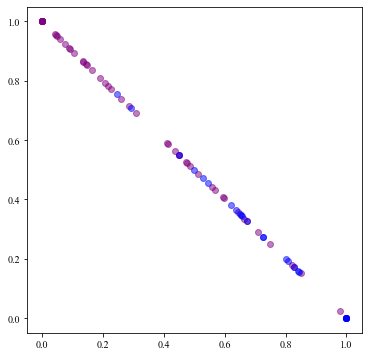

In [89]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(S[0,phase1_idx], S[1,phase1_idx], c='purple', marker='o', label='phase1', alpha=0.5)
ax.scatter(S[0,phase3_idx], S[1,phase3_idx], c='purple', marker='o', label='phase3', alpha=0.5)
ax.scatter(S[0,phase2_idx], S[1,phase2_idx], c='blue', marker='o', label='phase2', alpha=0.5)
plt.show()

In [90]:
ARI = []
NMI = []
for i in range(N):
    try:
        # Notice that for this implementation we transform the data matrix X
        XC, S, C, SSE, varexl = PCHA(X.copy().T, noc=2, verbose=False)
        S = np.array(S)
        ARI.append(adjusted_rand_score(phases, S.argmax(axis=0)))
        NMI.append(normalized_mutual_info_score(phases, S.argmax(axis=0)))
    except:
        continue

[[21.05764463 12.97126435]
 [12.97126435 30.99982666]]
295.7614188959053
[[25.4878715  12.90207336]
 [12.90207336 26.70798179]]
290.3553938393783
[[20.82500719 13.78612879]
 [13.78612879 29.60273524]]
291.06220476497367
[[25.70018817 13.48358961]
 [13.48358961 25.33263261]]
299.8897484509678
[[22.63012973 13.43841254]
 [13.43841254 28.4930452 ]]
289.9132972985294
[[28.04909479 13.57485675]
 [13.57485675 22.80119171]]
287.4545317240694
[[25.79417237 12.47000513]
 [12.47000513 27.26581738]]
293.14258723935075
[[28.09464883 12.68241979]
 [12.68241979 24.54051159]]
285.870040984869
[[23.31682916 13.40626897]
 [13.40626897 27.87063289]]
289.36853553857
[[26.20117912 13.35689782]
 [13.35689782 25.08502525]]
296.9566887444947
[[26.93214454 13.87980926]
 [13.87980926 23.30823695]]
287.6554993183722
[[24.00013145 12.4898803 ]
 [12.4898803  29.02010796]]
293.69339538159136
[[22.01947952 12.45911563]
 [12.45911563 31.06228923]]
294.73786742384743
[[28.68200443 12.9580149 ]
 [12.9580149  23.401965

In [91]:
print(f"ARI: {np.mean(ARI)} +- {np.std(ARI)}")
print(f"NMI: {np.mean(NMI)} +- {np.std(NMI)}")

ARI: 0.2105957620424142 +- 8.326672684688674e-17
NMI: 0.20586454158856035 +- 2.7755575615628914e-17


In [92]:
print(np.unique(phases[np.where(S.argmax(axis=0)==0)[0]], return_counts=True))
print(np.unique(phases[np.where(S.argmax(axis=0)==1)[0]], return_counts=True))
print(np.unique(phases[np.where(S.argmax(axis=0)==2)[0]], return_counts=True))

(array(['phase1', 'phase2', 'phase3'], dtype='<U6'), array([ 7, 23,  7]))
(array(['phase1', 'phase2', 'phase3'], dtype='<U6'), array([19,  3, 19]))
(array([], dtype='<U6'), array([], dtype=int64))


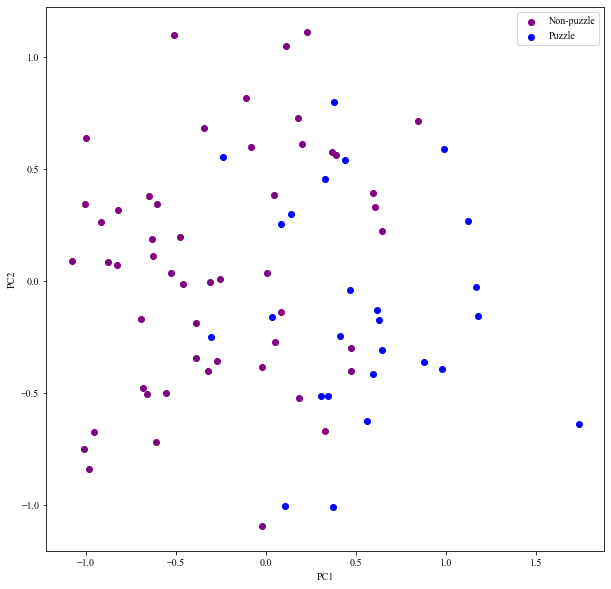

In [93]:
pca = PCA(n_components=2)
PC = pca.fit_transform(X.copy())

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(PC[phase1_idx, 0], PC[phase1_idx, 1], c='purple', label='Non-puzzle')
ax.scatter(PC[phase2_idx, 0], PC[phase2_idx, 1], c='blue', label='Puzzle')
ax.scatter(PC[phase3_idx, 0], PC[phase3_idx, 1], c='purple')
ax.legend()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()

In [94]:
ARI = []
NMI = []
for i in range(N):
    try:
        kmeans = KMeans(n_clusters=2).fit(X.copy())
        ARI.append(adjusted_rand_score(phases, kmeans.labels_))
        NMI.append(normalized_mutual_info_score(phases, kmeans.labels_))
    except:
        continue

In [95]:
print(f"ARI: {np.mean(ARI)} +- {np.std(ARI)}")
print(f"NMI: {np.mean(NMI)} +- {np.std(NMI)}")

ARI: 0.16511240270216393 +- 0.018749766624171018
NMI: 0.1741450113422324 +- 0.01766607027105387


In [96]:
ARI = []
NMI = []
for i in range(N):
    try:
        kmeans = KMeans(n_clusters=3).fit(X.copy())
        ARI.append(adjusted_rand_score(phases, kmeans.labels_))
        NMI.append(normalized_mutual_info_score(phases, kmeans.labels_))
    except:
        continue

In [97]:
print(f"ARI: {np.mean(ARI)} +- {np.std(ARI)}")
print(f"NMI: {np.mean(NMI)} +- {np.std(NMI)}")

ARI: 0.1451125145913547 +- 0.023675461750488982
NMI: 0.16713746229842258 +- 0.02401565957820732


In [98]:
print(np.unique(phases[np.where(kmeans.labels_==0)[0]], return_counts=True))
print(np.unique(phases[np.where(kmeans.labels_==1)[0]], return_counts=True))

(array(['phase1', 'phase2', 'phase3'], dtype='<U6'), array([ 3, 15,  4]))
(array(['phase1', 'phase2', 'phase3'], dtype='<U6'), array([7, 9, 8]))


In [99]:
ARI = []
NMI = []
for i in range(N):
    try:
        kmeans = KMeans(n_clusters=2).fit(PC.copy())
        ARI.append(adjusted_rand_score(phases, kmeans.labels_))
        NMI.append(normalized_mutual_info_score(phases, kmeans.labels_))
    except:
        continue

In [100]:
print(f"ARI: {np.mean(ARI)} +- {np.std(ARI)}")
print(f"NMI: {np.mean(NMI)} +- {np.std(NMI)}")

ARI: 0.1565944507791714 +- 2.7755575615628914e-17
NMI: 0.1685703310702134 +- 2.7755575615628914e-17


In [101]:
print(np.unique(phases[np.where(kmeans.labels_==0)[0]], return_counts=True))
print(np.unique(phases[np.where(kmeans.labels_==1)[0]], return_counts=True))

(array(['phase1', 'phase2', 'phase3'], dtype='<U6'), array([10, 24, 10]))
(array(['phase1', 'phase2', 'phase3'], dtype='<U6'), array([16,  2, 16]))


In [102]:
ARI = []
NMI = []
for i in range(N):
    try:
        kmeans = KMeans(n_clusters=3).fit(PC.copy())
        ARI.append(adjusted_rand_score(phases, kmeans.labels_))
        NMI.append(normalized_mutual_info_score(phases, kmeans.labels_))
    except:
        continue

In [103]:
print(f"ARI: {np.mean(ARI)} +- {np.std(ARI)}")
print(f"NMI: {np.mean(NMI)} +- {np.std(NMI)}")

ARI: 0.16138838877246833 +- 0.0
NMI: 0.17906351947092042 +- 7.923718583280447e-17


In [104]:
print(np.unique(phases[np.where(kmeans.labels_==0)[0]], return_counts=True))
print(np.unique(phases[np.where(kmeans.labels_==1)[0]], return_counts=True))
print(np.unique(phases[np.where(kmeans.labels_==2)[0]], return_counts=True))

(array(['phase1', 'phase2', 'phase3'], dtype='<U6'), array([ 4, 18,  4]))
(array(['phase1', 'phase2', 'phase3'], dtype='<U6'), array([15,  1, 13]))
(array(['phase1', 'phase2', 'phase3'], dtype='<U6'), array([7, 7, 9]))
